In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import dataset

current_os = 'mac'
if current_os == 'mac':
    path = '/Users/fabienaugsburger/Documents/GitHub/master-project/'
elif current_os == 'win':
    path = 'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    print('Error: OS not recognized')

# load data

dataset = 'X_y_EU_1h'
osaa = 2

if osaa == '':
    X_train = np.load(path + f'DATASETS/{dataset}/X_train.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation.npy')
else:
    X_train = np.load(path + f'DATASETS/{dataset}/X_train_{osaa}.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test_{osaa}.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train_{osaa}.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test_{osaa}.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation_{osaa}.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation_{osaa}.npy')



names = pd.read_csv(path + f'variable_list_24_v5_wo_i.csv')

if osaa == 2:
    X_train=pd.DataFrame(X_train, columns=names['variables'])
    X_test=pd.DataFrame(X_test, columns=names['variables'])
    X_validation=pd.DataFrame(X_validation, columns=names['variables'])
    
    y_train=pd.DataFrame(y_train, columns=['instantaneous_10m_wind_gust_0'])
    y_test=pd.DataFrame(y_test, columns=['instantaneous_10m_wind_gust_0'])
    y_validation=pd.DataFrame(y_validation, columns=['instantaneous_10m_wind_gust_0'])

In [6]:
# create an xgboost model

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#y_train = y_train.values.ravel()
#y_test = y_test.values.ravel()

# read in the split dataset into an optimized data structure called Dmatrix required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_validation, label=y_validation)
dtest = xgb.DMatrix(X_test, label=y_test)

base_score = np.mean(y_train)

#Set hyperparameters for model training
# Set hyperparameters for model training
params = {
   'objective': 'binary:logistic',
   'eval_metric': 'logloss',
   'eta': 0.01,
   'base_score': base_score,
   'seed': 42
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'X_train'), (dvalid, 'X_validation')]
model = xgb.train(params, dtrain,                  
                       num_boost_round=5000,                    
                       evals=watchlist,
                       early_stopping_rounds=20,
                       verbose_eval=100)

XGBoostError: [13:55:26] /Users/runner/work/xgboost/xgboost/src/objective/./regression_loss.h:69: Check failed: base_score > 0.0f && base_score < 1.0f: base_score must be in (0,1) for logistic loss, got: 13.8729
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000305590e28 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000305815018 xgboost::obj::LogisticRegression::ProbToMargin(float) + 176
  [bt] (2) 3   libxgboost.dylib                    0x00000003057844f4 xgboost::LearnerConfiguration::ConfigureModelParamWithoutBaseScore() + 216
  [bt] (3) 4   libxgboost.dylib                    0x000000030577726c xgboost::LearnerConfiguration::Configure() + 960
  [bt] (4) 5   libxgboost.dylib                    0x00000003055b1b2c XGBoosterBoostedRounds + 100
  [bt] (5) 6   libffi.8.dylib                      0x0000000104f9004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000104f8d834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000104de0988 _ctypes_callproc + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104ddac10 PyCFuncPtr_call + 1188



In [3]:
%%time
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X) 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf6 in position 4065: invalid start byte

In [15]:
# fit the model

model.train(X_train, y_train, eval_set=[(X_validation, y_validation)], verbose=2)

AttributeError: 'XGBRegressor' object has no attribute 'train'

Mean Squared Error: 5.149497257825466


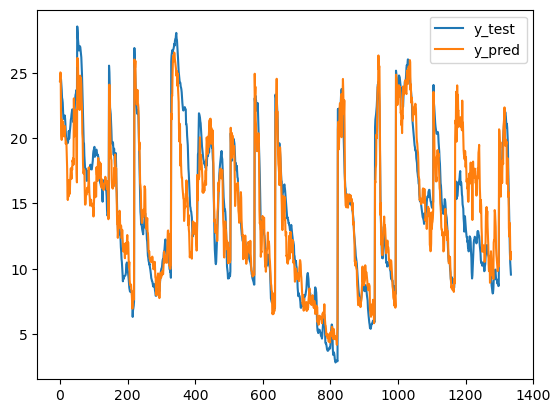

In [12]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# plot y_test and y_pred

plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [14]:
# using shap, see the most important features

import shap

model.set_param({"predictor": "gpu_predictor"})
explainer_gpu = shap.TreeExplainer(model=model)
shap_values_gpu = explainer_gpu.shap_values(X)

AttributeError: 'XGBRegressor' object has no attribute 'set_param'

[0]	train-rmse:5.80220	valid-rmse:5.70612
[100]	train-rmse:2.56765	valid-rmse:3.07098
[200]	train-rmse:1.40988	valid-rmse:2.43025
[300]	train-rmse:0.97781	valid-rmse:2.28902
[400]	train-rmse:0.78605	valid-rmse:2.26389
[500]	train-rmse:0.67876	valid-rmse:2.25256
Mean Squared Error: 4.992896350529722


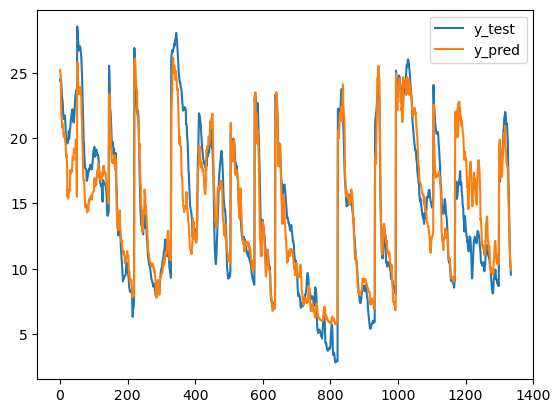

In [19]:
import xgboost as xgb
import shap

#y_train = y_train.values.ravel()
#y_test = y_test.values.ravel()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_validation, label=y_validation)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.01,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, num_boost_round=5000, evals=watchlist, early_stopping_rounds=20, verbose_eval=100)

y_pred = model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [20]:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X_train)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf6 in position 4065: invalid start byte